# *Projet P3: Concevez une application au service de la santé publique*






In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

plt.style.use('seaborn-whitegrid')

In [2]:
## Outil de visualisation a installer 
## pip install missingno 

In [3]:
import missingno as mso

## Présentation des informations disponibles

In [4]:
mon_fichier = 'donnee/fr.openfoodfacts.org.products.csv'

**Lecture du fichier en échantillonnant les lignes**

In [5]:
def lecture_fichier(mon_fichier, echantillon=True):
    '''
    Lecture du fichier de donnee csv, retourne un DataFrame data
    
    mon_fichier: nom du fichier
    echantillon=False : lecture de tout le fichier
    echantillon=True : lecture d´un echantillon de 10000 lignes
    '''
    
    ## on impose un dtype aux colonnes qui ont un dtype mélangé
    ## cela evite les warnings a la lecture
    liste_colonne_dtypes_object = ['code','abbreviated_product_name', 'packaging_text', 
                               'manufacturing_places','manufacturing_places_tags', 'emb_codes', 
                               'emb_codes_tags','first_packaging_code_geo', 'cities_tags',
                               'additives','ingredients_from_palm_oil_tags', 
                               'ingredients_that_may_be_from_palm_oil_tags',
                               'brand_owner'] 
    liste_dtypes = []
    for colonne in liste_colonne_dtypes_object:
        liste_dtypes.append((colonne,'string'))
    liste_dtypes.append(('energy-kj_100g','float64'))
    liste_dtypes.append(('energy_100g','float64'))
  
    dict_dtypes = dict(liste_dtypes)
    
    ## lecture sur un echantillon du fichier
    if echantillon: 
        
        ## Calcul du nombre de ligne du fichier : 1,8 Millions de lignes
        with open(mon_fichier, 'r', encoding="utf8") as file:
            nombre_ligne_fichier = 0
            for line in file:
                nombre_ligne_fichier += 1
                
        ## On tire au sort sans remise les lignes que l´on va lire
        n_lignes = 10000
        ligne_lecture = random.sample(range(1,nombre_ligne_fichier),n_lignes)
        ligne_lecture.append(0) ## on lit la premiere ligne dans tous les cas
        ligne_lecture.sort()
        ligne_lecture_exclue = list(set(range(nombre_ligne_fichier))-set(ligne_lecture))

        ## Lecture du fichier en excluant toutes les lignes sauf celles tirees au sort
        data = pd.read_csv( mon_fichier,sep='\t',
                           encoding='utf_8', 
                           skiprows = ligne_lecture_exclue,
                           dtype=dict_dtypes ) 
    ## lecture complete
    else:    
        data = pd.read_csv( mon_fichier,sep='\t',
                           encoding='utf_8', 
                           dtype=dict_dtypes )
    return data

In [6]:
def ecriture_fichier(data,mon_fichier):
    '''
    Enregistre les resultats au format csv,
    le nom de fichier finit par "_pretraitement.csv"
    ''' 
    fichier, fichier_extension = os.path.splitext(mon_fichier)
    fichier_sauvegarde = fichier + '_pretraitement' + fichier_extension
    data.to_csv(fichier_sauvegarde)

In [7]:
data = lecture_fichier(mon_fichier,echantillon=False)

In [8]:
data.info() ## 186 colonnes. il y a des dtypes object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842094 entries, 0 to 1842093
Columns: 186 entries, code to carnitine_100g
dtypes: float64(123), int64(2), object(48), string(13)
memory usage: 2.6+ GB


**Visualisation des valeurs manquantes**

In [9]:
## Repartition du taux de valeurs manquantes
data.isna().mean().describe()

count    186.000000
mean       0.796531
std        0.322143
min        0.000000
25%        0.739439
50%        0.992144
75%        0.999927
max        1.000000
dtype: float64

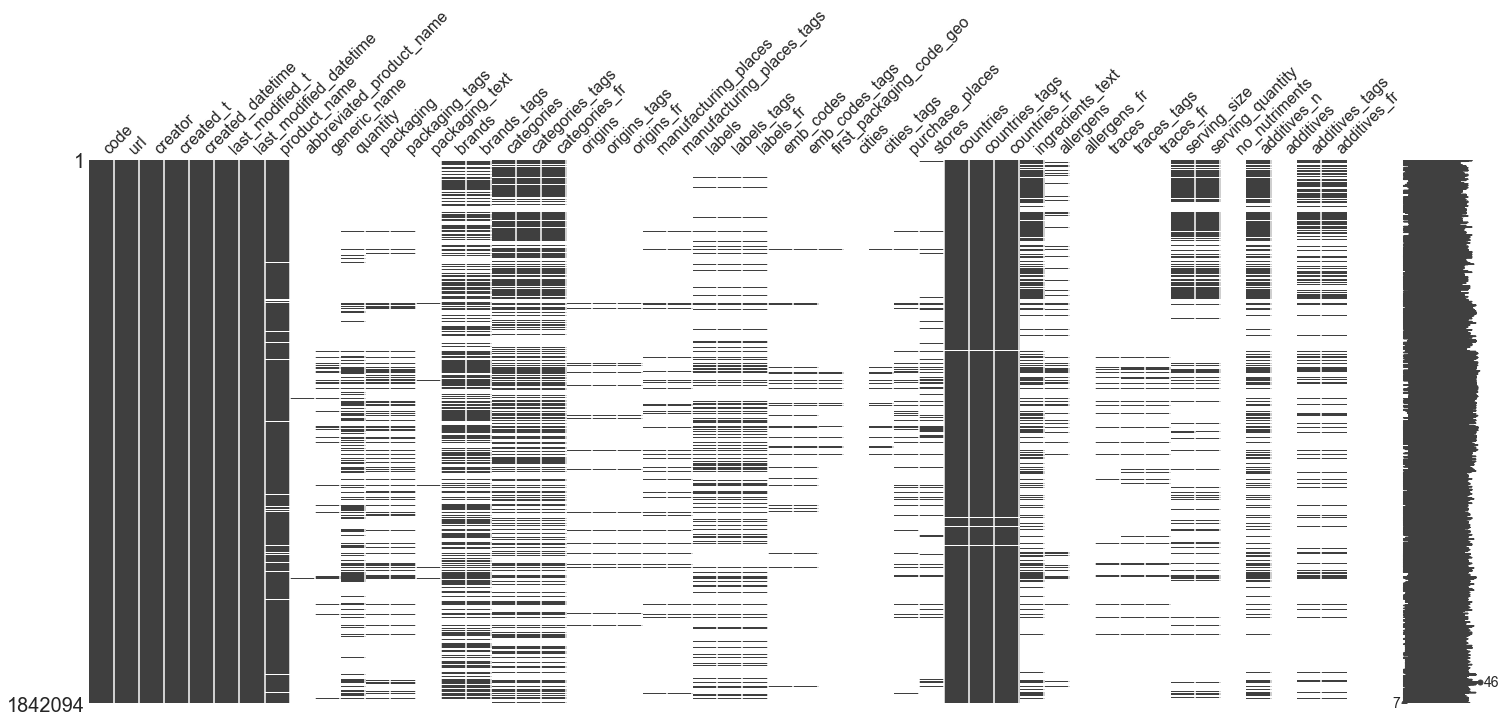

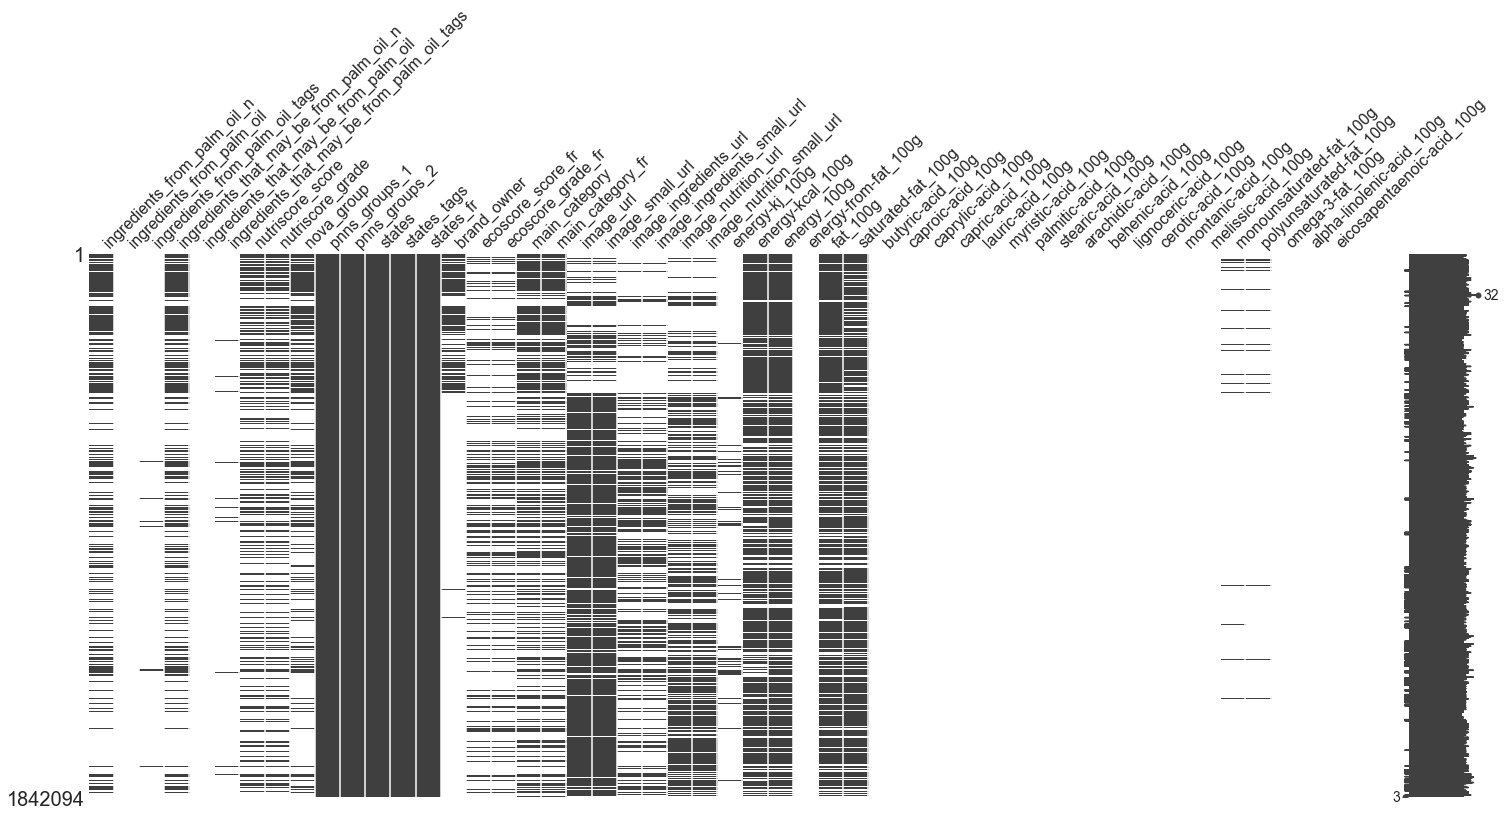

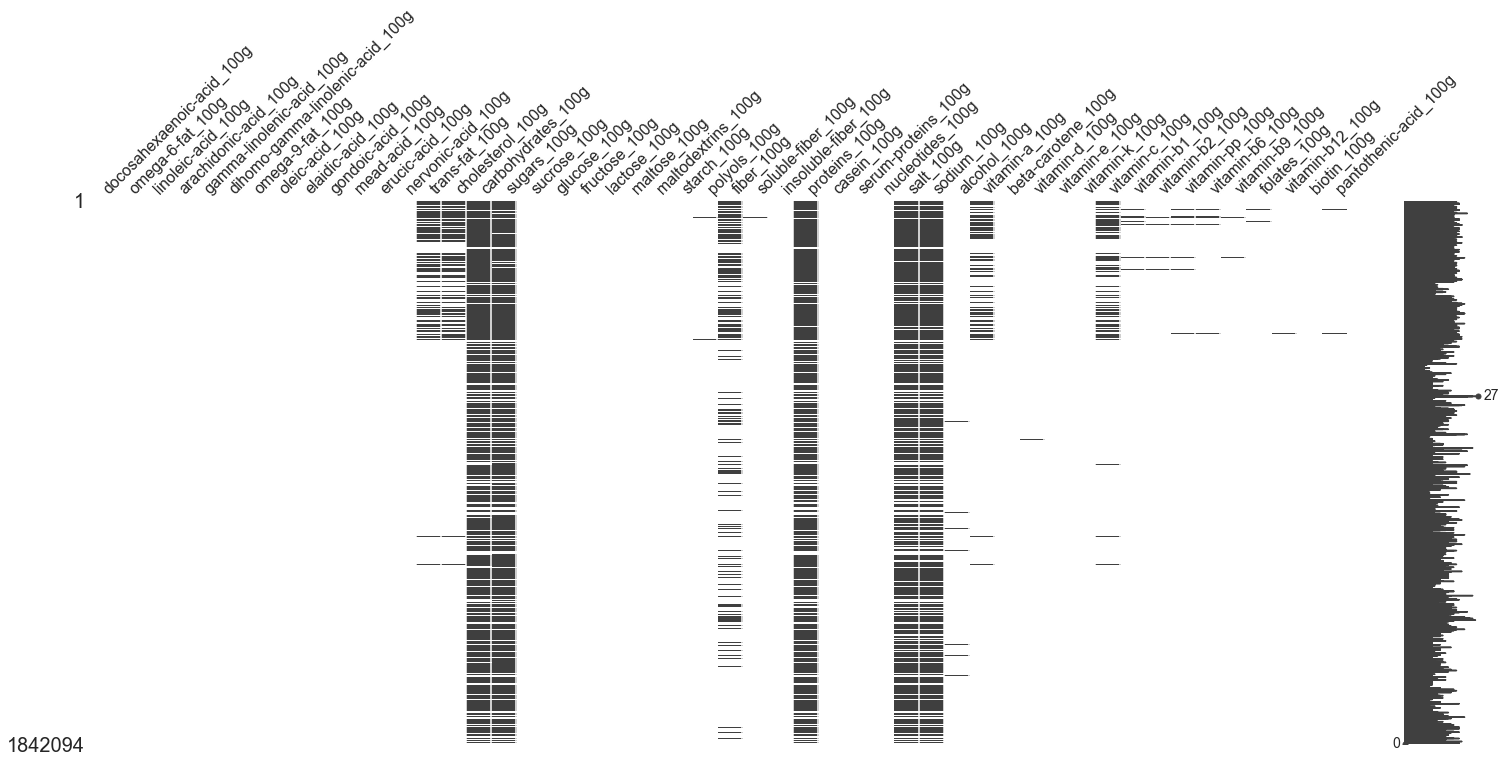

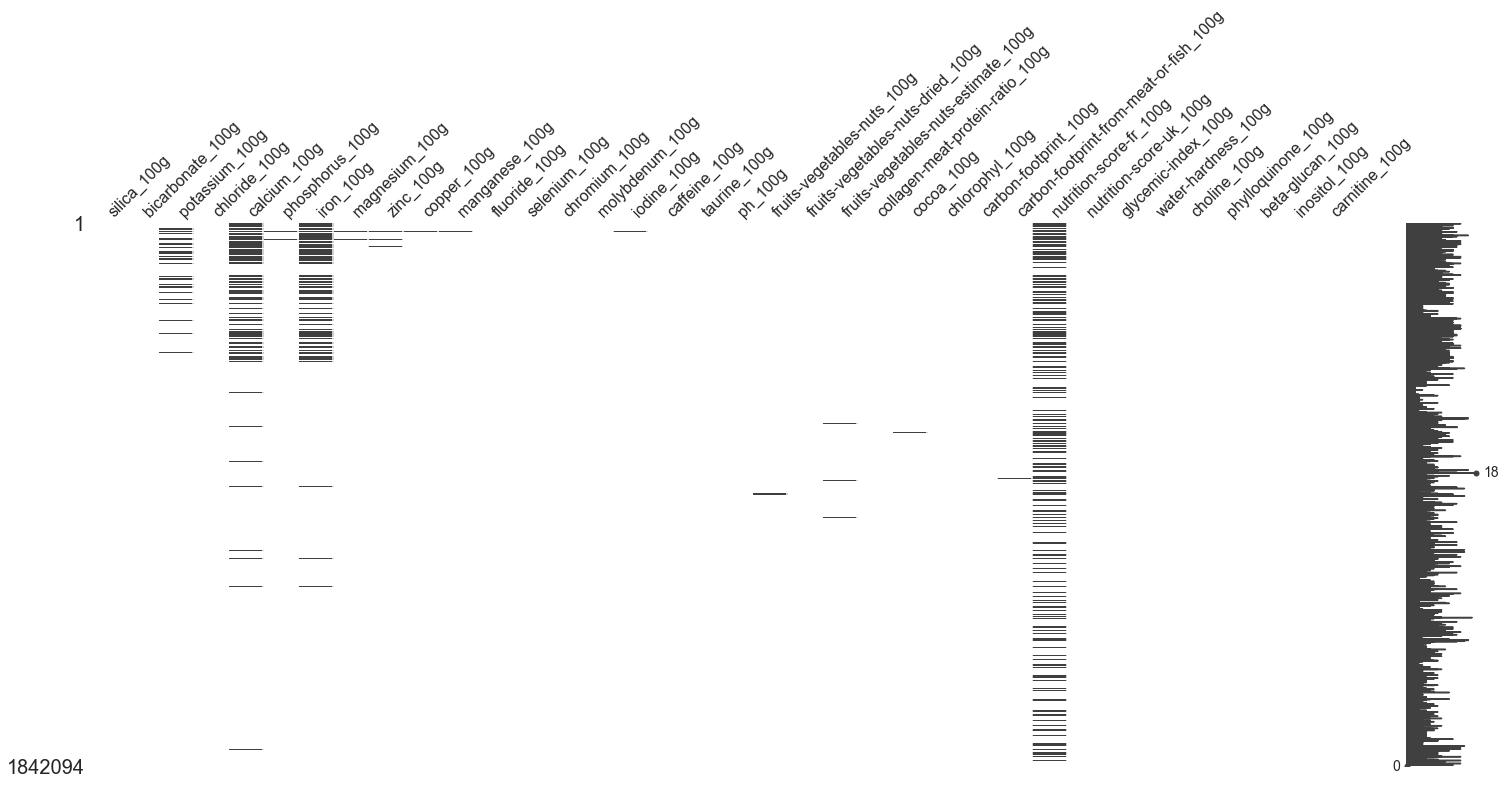

In [10]:
## Graphique: visualisation des données brutes
## on reparti sur 4 graphes , 50 colonnes chacun
## ici on regarde le remplissage par lignes et colonnes
for ind_graph in range(4): 
    mso.matrix(data.iloc[:,50*ind_graph:50*(ind_graph+1)])

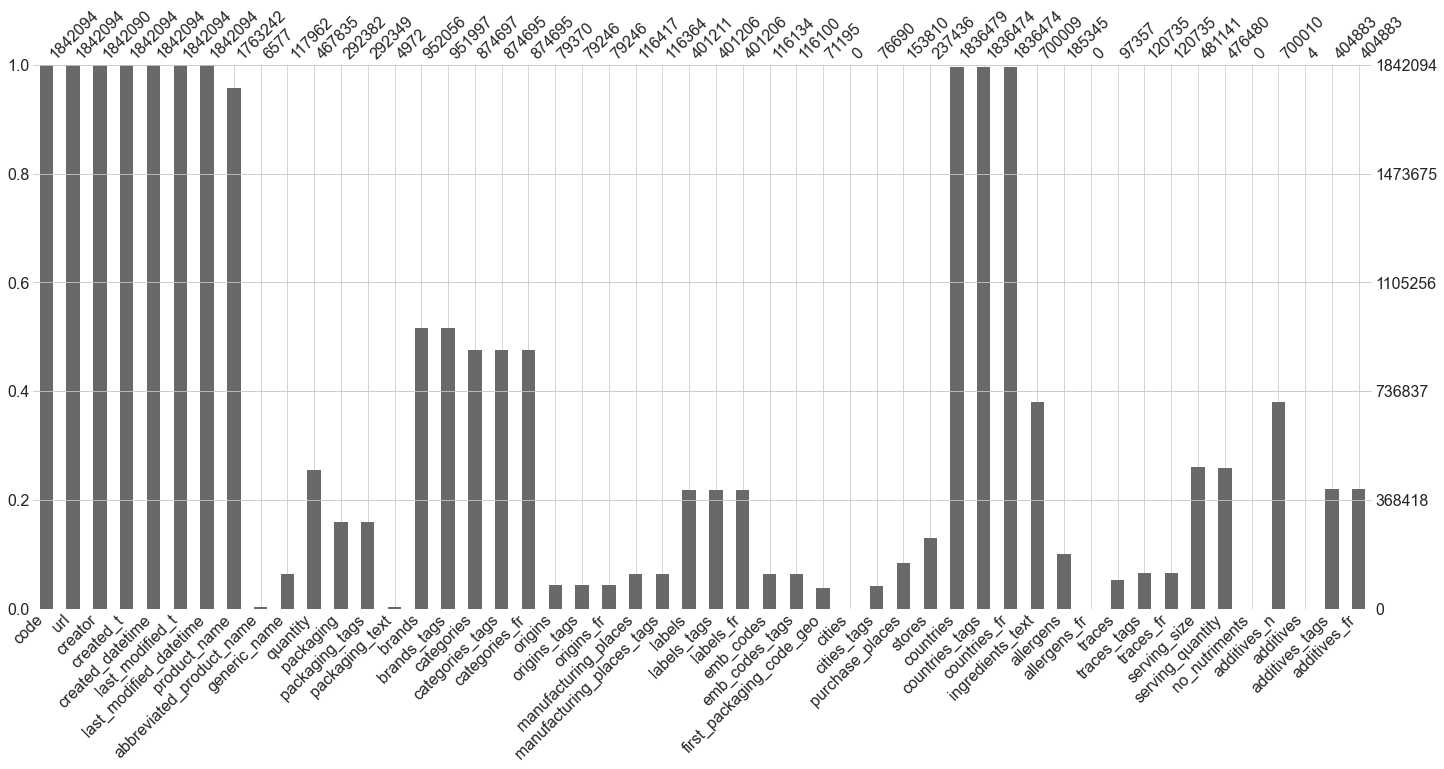

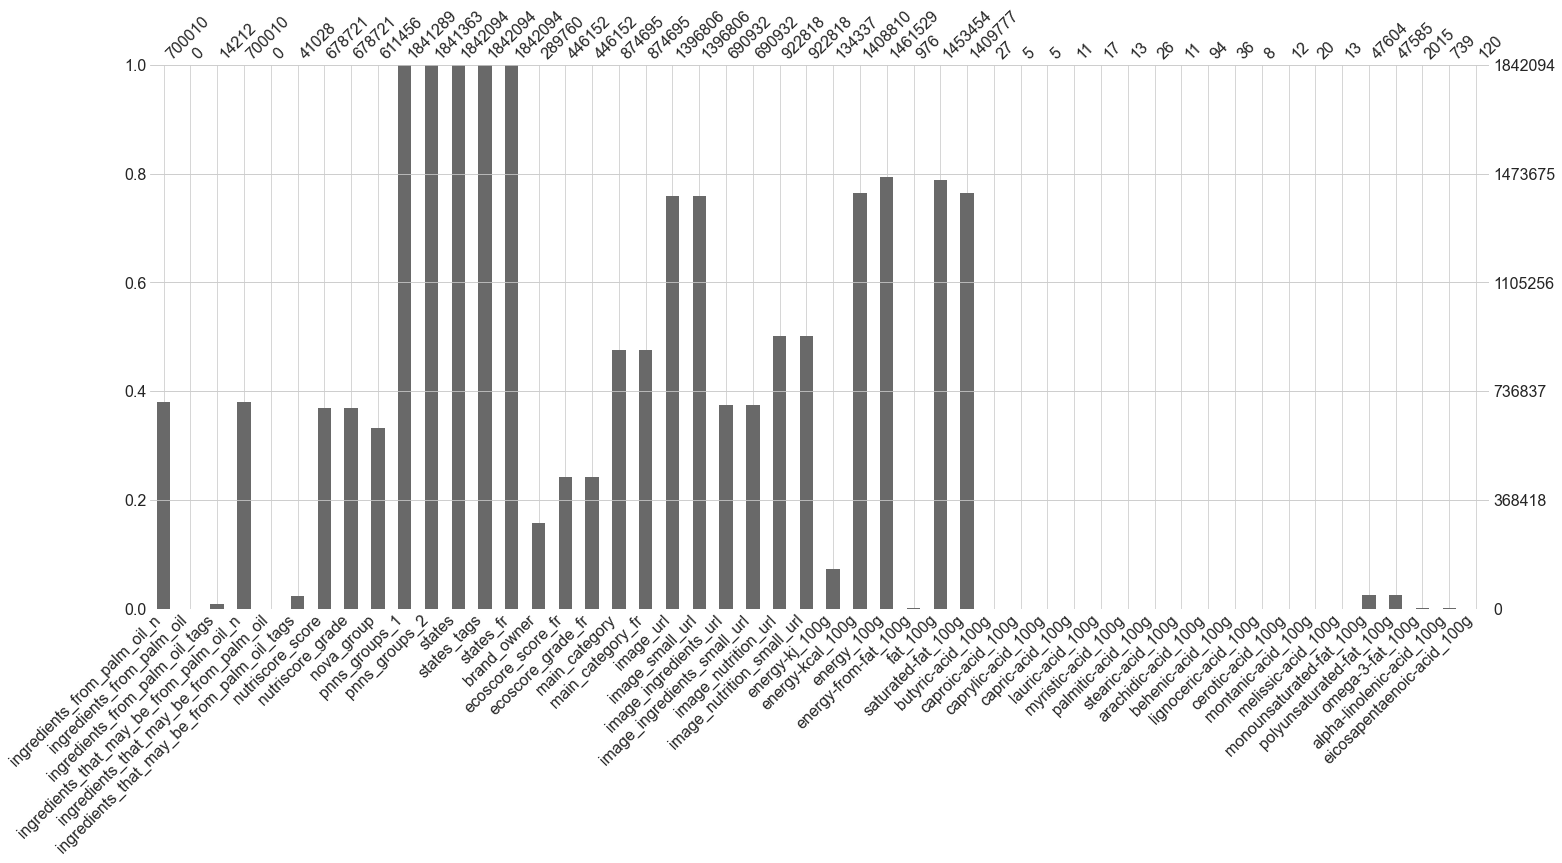

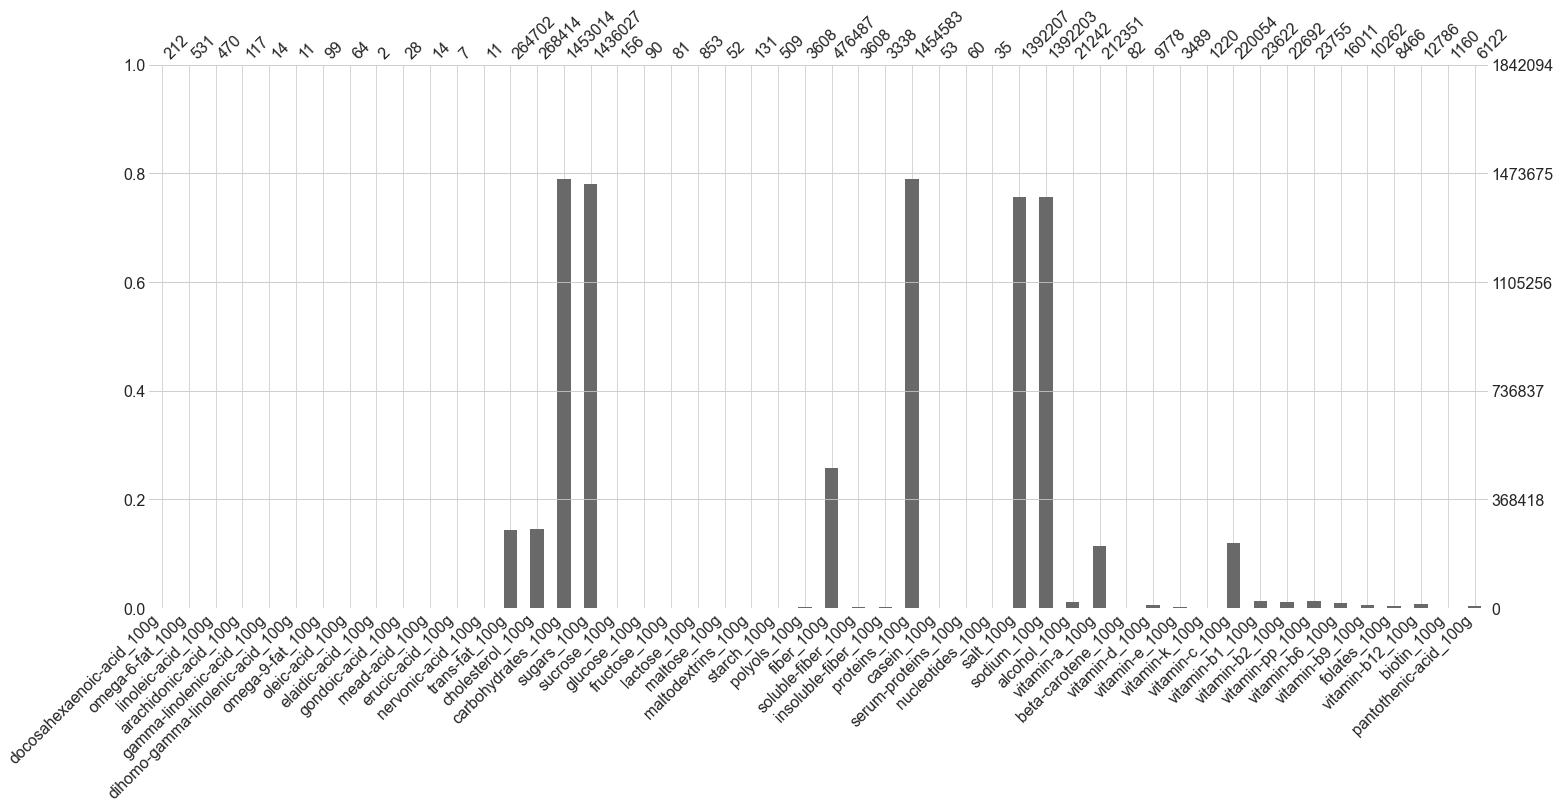

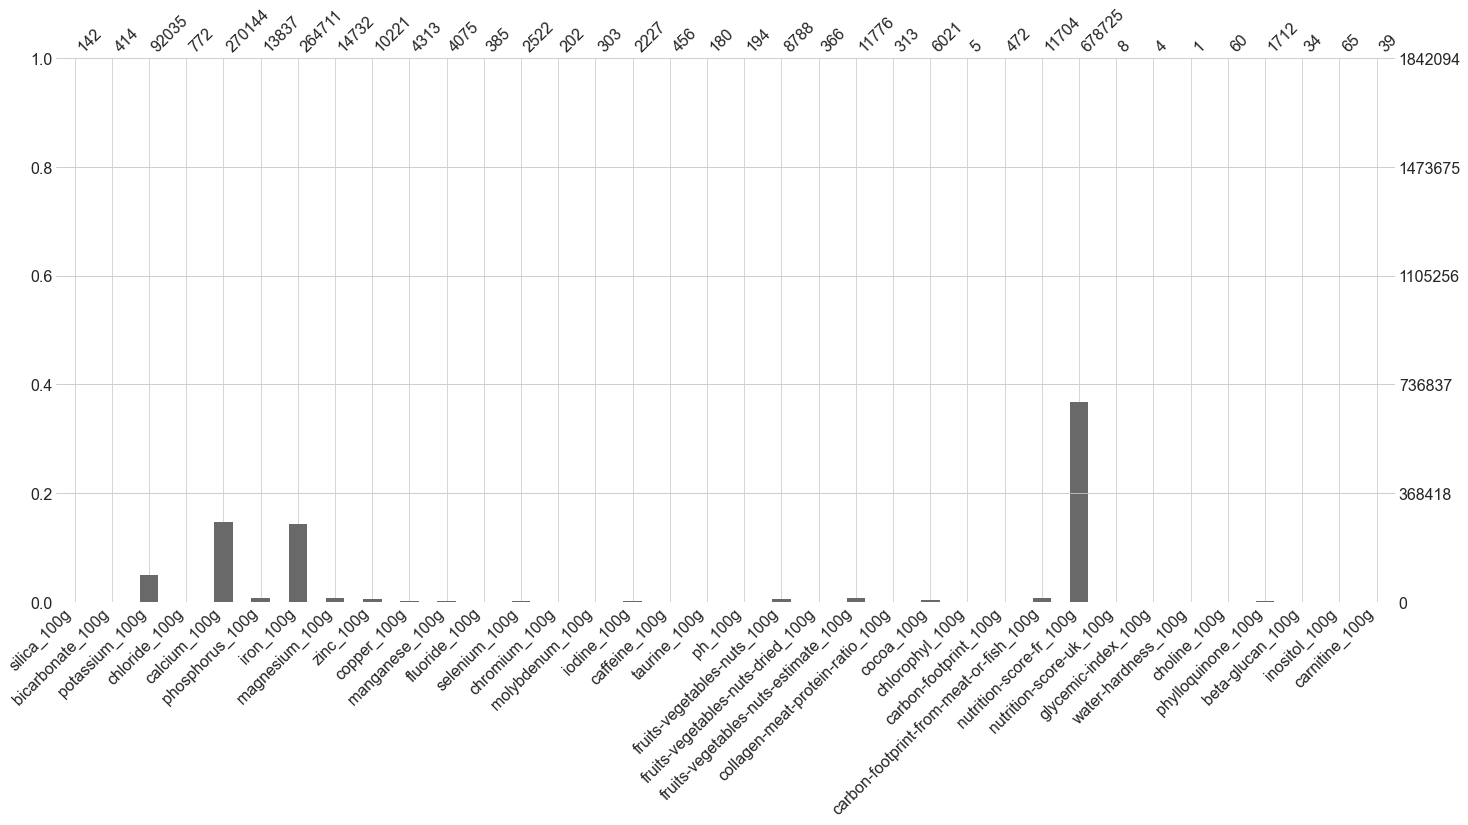

In [11]:
## Graphique: visualisation des données brutes 
## on reparti sur 4 graphes , 50 colonnes chacun
## ici on regarde le nombre de lignes renseignées par colonnes
for ind_graph in range(4):
    plt.figure(ind_graph)
    mso.bar(data.iloc[:,50*ind_graph:50*(ind_graph+1)])

**On enleve les colonnes remplies à moins de x %**

sauf les fruits, ils interviennent dans le calcul du nutriscore.

In [12]:
data.columns[data.columns.str.contains('fruit')]

Index(['fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g',
       'fruits-vegetables-nuts-estimate_100g'],
      dtype='object')

In [13]:
mask = data['fruits-vegetables-nuts-estimate_100g'].notna()
data[mask]['pnns_groups_1'].shape

(11776,)

In [14]:
mask = data['fruits-vegetables-nuts_100g'].notna()
data[mask]['pnns_groups_1'].shape

(8788,)

In [15]:
def retire_colonne(data):
    '''Enleve les colonnes vide a 99 % du dataframe data
    et retourne le dataframe'''
    
    ## nombre de colonnes remplies au minimum a 1%
    sous_ensemble = data.columns[data.count()>=(1/100)*data.shape[0]].to_list()
    sous_ensemble.append('fruits-vegetables-nuts-estimate_100g')
    return data[sous_ensemble].copy()

In [16]:
data.shape

(1842094, 186)

In [17]:
data = retire_colonne(data)

In [18]:
data.shape

(1842094, 92)

**On groupe les colonnes par themes:**

- general information: general_information  
- tags: tags  
- ingredients: ingredients  
- misc. data: misc 
- nutrition facts: nutrition_facts  


In [19]:
def decoupage(data):
    """decoupage en categorie"""
    
    data_general_information = data.loc[:,:'quantity']
    data_tags = data.loc[:,'packaging':'countries_fr']
    data_ingredients = data.loc[:,'ingredients_text':'traces_fr']
    data_misc = data.loc[:,'serving_size':'image_nutrition_small_url']
    data_nutrition_facts = data.loc[:,'energy-kj_100g':]

    ## On verifie que l´on a pas oublié de colonnes dans le decoupage en categories
    data_set_decoupage = set(data_general_information.columns.to_list()).union(data_nutrition_facts.columns,
                                                         data_misc.columns,
                                                         data_ingredients.columns,
                                                         data_tags.columns,
                                                         data_general_information.columns)
    data_set_original = set(data.columns)
    data_set_difference = data_set_original.difference(data_set_decoupage)
    if data_set_difference != set():
        print("Il manque {} après le decoupage: ".format(data_set_difference))
            
    return [data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts] 

In [20]:
[data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts] = decoupage(data)

**On selectionne des colonnes pour chaque thème**

In [21]:
def selection_colonnes(data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts):

    ## Champs General information
    ## data_general_information.columns.to_list()
    mes_champs = ['code',
                  'url',
                  'creator',
                  'created_t',
                  'created_datetime',
                  'last_modified_t',
                  'last_modified_datetime',
                  'product_name',
                  'quantity' ]
    data_general_information = data_general_information[mes_champs].copy()

    ## Champs Tags
    ## data_tags.columns.to_list()
    mes_champs = ['packaging',
                  'brands',
                  'categories_fr',
                  'origins_fr',
                  'manufacturing_places',
                  'labels_fr',
                  'purchase_places',
                  'stores',
                  'countries_fr']
    data_tags = data_tags[mes_champs].copy()
    
    ## Champs Ingredients
    ## data_ingredients.columns.to_list()
    mes_champs = ['ingredients_text',
                  'allergens',
                  'traces_fr']
    data_ingredients = data_ingredients[mes_champs].copy()
    
    ## Champs Misc
    ## data_misc.columns.to_list()
    mes_champs = [
     'additives_n',
     'additives_fr',
     'nutriscore_score',
     'nutriscore_grade',
     'nova_group',
     'pnns_groups_1',
     'pnns_groups_2',
     'brand_owner',
     'ecoscore_score_fr',
     'ecoscore_grade_fr',
     'main_category_fr',
    ]
    data_misc = data_misc[mes_champs].copy()
    
    ## Champs Nutrition facts
    data_nutrition_facts.columns.to_list()
    mes_champs = [
        'energy-kcal_100g',
        'energy_100g',
        'fat_100g',
        'saturated-fat_100g',
        'carbohydrates_100g',
        'sugars_100g',
        'fiber_100g',
        'proteins_100g',
        'salt_100g',
        'sodium_100g',
        'fruits-vegetables-nuts-estimate_100g',
        'nutrition-score-fr_100g'
    ]
    data_nutrition_facts = data_nutrition_facts[mes_champs].copy()
    
    return [data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts]

In [22]:
[data_general_information,
 data_tags,
 data_ingredients,
 data_misc,
 data_nutrition_facts] = selection_colonnes(data_general_information,
                                              data_tags,
                                              data_ingredients,
                                              data_misc,
                                              data_nutrition_facts)

In [23]:
data = pd.concat([data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts],axis=1)

In [24]:
data.shape

(1842094, 44)

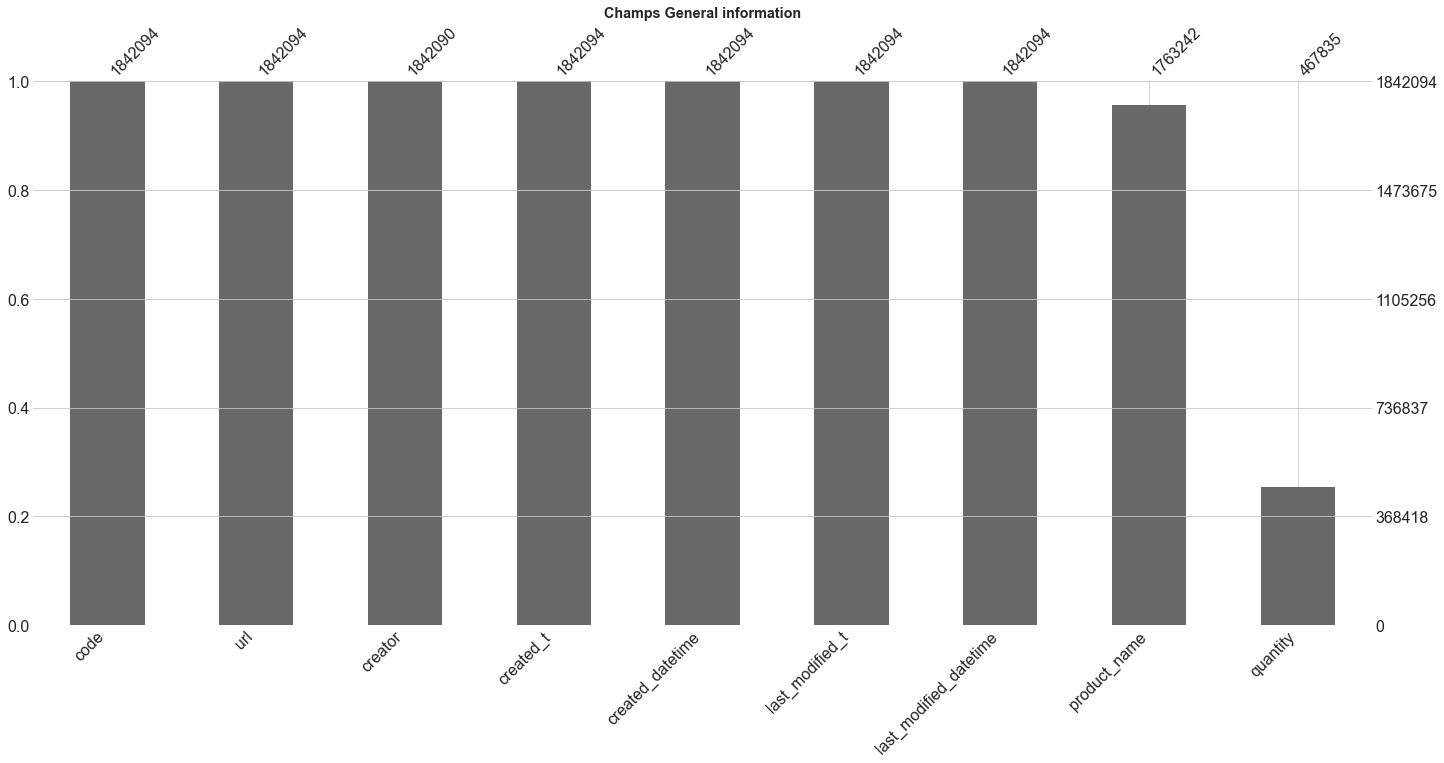

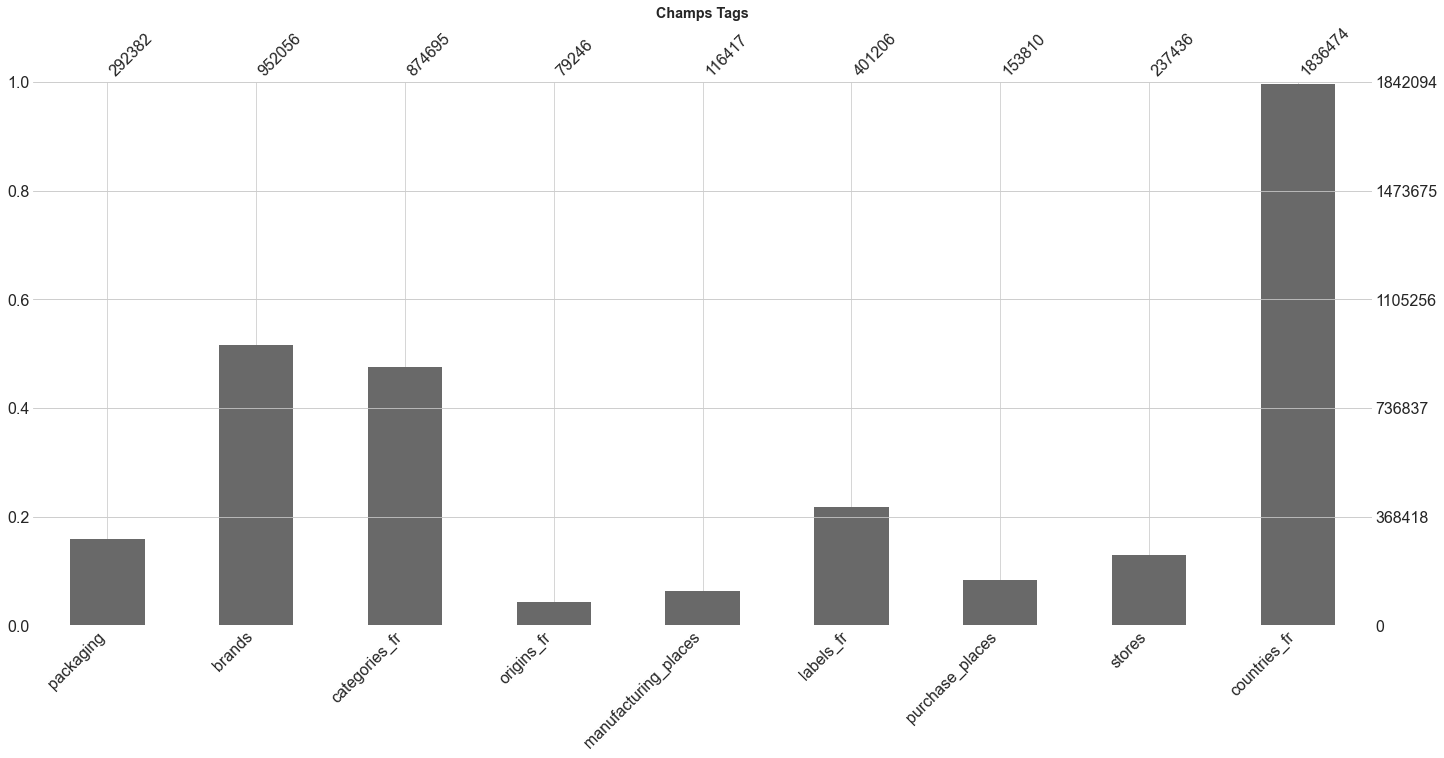

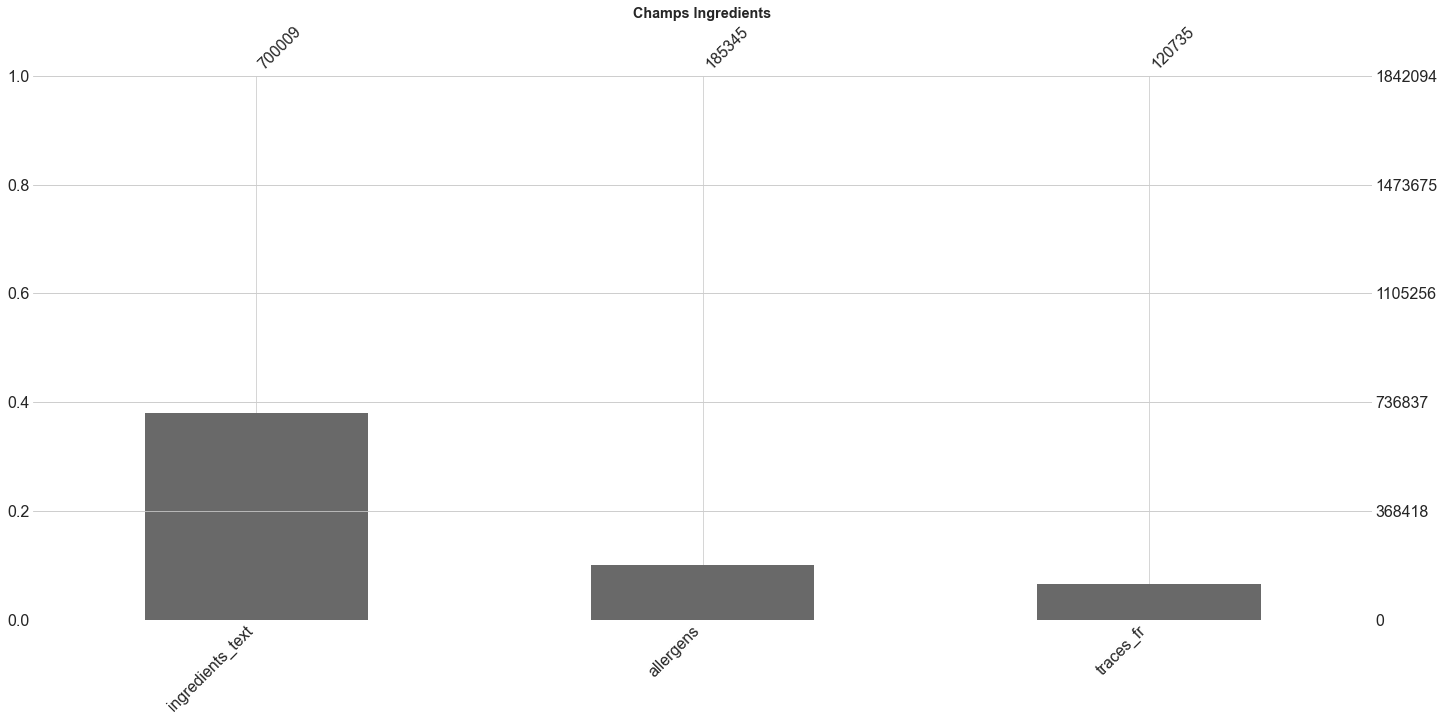

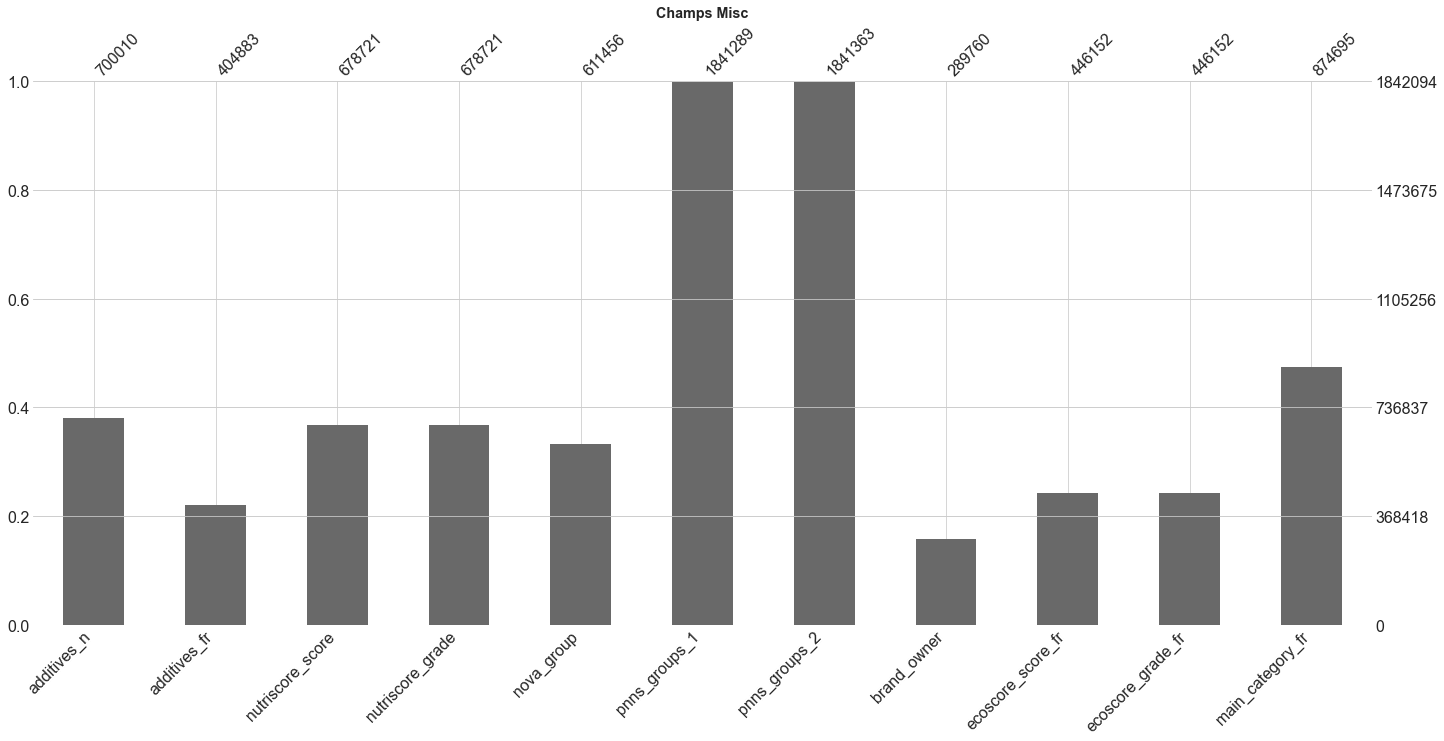

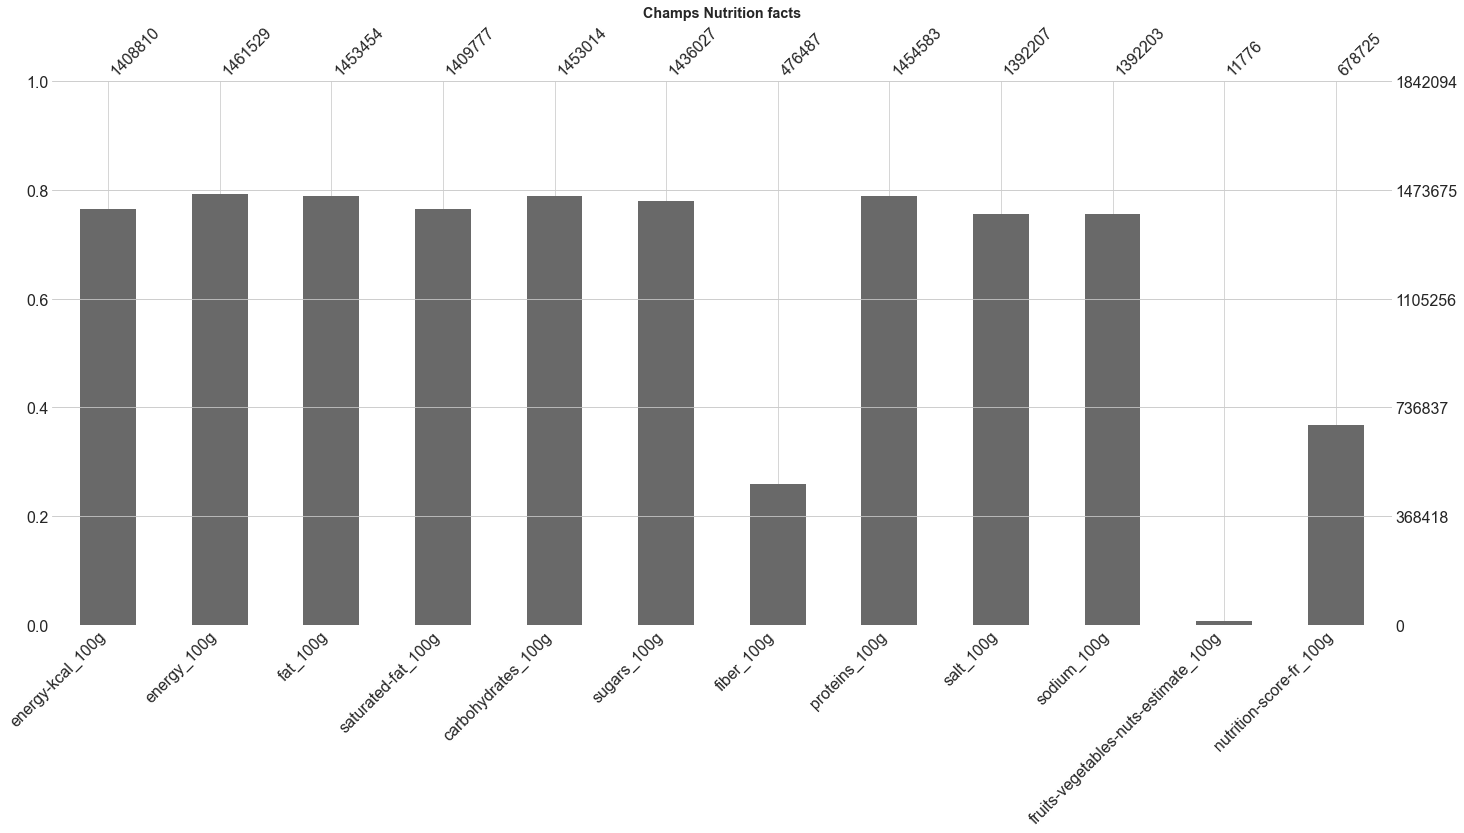

In [25]:
plt.rcParams.update({'font.size': 12})

plt.figure()
mso.bar(data_general_information)
plt.title("Champs General information",fontweight='semibold')

plt.figure()
mso.bar(data_tags)
plt.title("Champs Tags",fontweight='semibold')

plt.figure()
mso.bar(data_ingredients)
plt.title("Champs Ingredients",fontweight='semibold')

plt.figure()
mso.bar(data_misc)
plt.title("Champs Misc",fontweight='semibold')

plt.figure()
mso.bar(data_nutrition_facts)
plt.title("Champs Nutrition facts",fontweight='semibold');

**Filtre sur les lignes : informations nutritionelles**

In [26]:
def selection_ligne_nutrition(data):
    ## on selectionne les lignes avec l´energie renseignée
    masque_info_nutrition = data["energy_100g"].notna() 
    masque_ingredient = True ##data_ingredients["ingredients_text"].notna()
    masque_produits = masque_ingredient & masque_info_nutrition
    return data[masque_produits].copy()

In [27]:
data.shape

(1842094, 44)

In [28]:
data = selection_ligne_nutrition(data)

In [29]:
data.shape

(1461529, 44)

**Filtre sur les lignes : Categorie**

On regroupe les noms des categories qui sont ecrits un peu differemment.

In [30]:
data["pnns_groups_2"].value_counts()

unknown                             829396
Biscuits and cakes                   58501
Sweets                               58369
Dressings and sauces                 45253
Cheese                               40778
One-dish meals                       39573
Cereals                              36587
Processed meat                       34342
Milk and yogurt                      31099
Fish and seafood                     24000
Meat                                 22555
Vegetables                           20846
Sweetened beverages                  20717
Bread                                19843
Fats                                 18858
Chocolate products                   13339
Salty and fatty products             12636
Fruits                               12415
Appetizers                           10308
Unsweetened beverages                 9456
Artificially sweetened beverages      8885
Breakfast cereals                     8663
Fruit juices                          8418
Legumes    

In [31]:
len(data["pnns_groups_2"].unique())

47

In [32]:
# on regroupe les categories qui ont le meme nom. La seule difference est l´ecriture en minuscules ald capitalized 
categorie_set = set(data["pnns_groups_2"].unique()).intersection(set(data["pnns_groups_2"].str.lower().unique()))
print(categorie_set)

{'unknown', 'fruits', 'vegetables', 'legumes', 'cereals', 'nuts', 'pastries'}


In [33]:
categorie_set.remove('unknown')

In [34]:
categorie_set

{'cereals', 'fruits', 'legumes', 'nuts', 'pastries', 'vegetables'}

In [35]:
for nom in categorie_set:
    masque = data["pnns_groups_2"].isin([nom])
    data.loc[masque,"pnns_groups_2"]= nom.capitalize()

In [36]:
len(data["pnns_groups_2"].unique())

41

In [37]:
data["pnns_groups_2"].unique()

array(['unknown', 'Dressings and sauces', 'One-dish meals',
       'Biscuits and cakes', 'Fruits', 'Cheese', 'Meat', 'Bread',
       'Fish and seafood', 'Salty and fatty products', 'Fruit juices',
       'Sweets', 'Vegetables', 'Fats', 'Dairy desserts', 'Pastries',
       'Dried fruits', 'Pizza pies and quiches', 'Sweetened beverages',
       'Unsweetened beverages', 'Pizza pies and quiche', 'Nuts',
       'Cereals', 'Appetizers', 'Processed meat', 'Breakfast cereals',
       'Chocolate products', 'Milk and yogurt', 'Eggs',
       'Plant-based milk substitutes', 'Sandwiches', 'Legumes',
       'Teas and herbal teas and coffees', 'Soups', 'Potatoes',
       'Artificially sweetened beverages', 'Waters and flavored waters',
       'Ice cream', 'Alcoholic beverages', 'Offals', 'Fruit nectars'],
      dtype=object)

In [38]:
data["pnns_groups_1"].value_counts()

unknown                    829396
Sugary snacks              133927
Milk and dairy products     84386
Fish Meat Eggs              84358
Cereals and potatoes        75534
Fat and sauces              64111
Beverages                   59531
Composite foods             51063
Fruits and vegetables       41130
Salty snacks                29893
fruits-and-vegetables        4810
Alcoholic beverages          2402
sugary-snacks                 882
cereals-and-potatoes           36
salty-snacks                    4
Name: pnns_groups_1, dtype: int64

In [39]:
## On regroupe les noms quasi identiques du pnns_group_1
def change_nom_categorie(categorie_old,categorie_new):
    masque = data["pnns_groups_1"].isin([categorie_old])
    data.loc[masque,"pnns_groups_1"]= categorie_new
    return data.copy()

categorie_old = 'fruits-and-vegetables'
categorie_new = 'Fruits and vegetables'
data = change_nom_categorie(categorie_old,categorie_new)

categorie_old = 'sugary-snacks'
categorie_new = 'Sugary snacks'
data = change_nom_categorie(categorie_old,categorie_new)

categorie_old = 'cereals-and-potatoes'
categorie_new = 'Cereals and potatoes'
data = change_nom_categorie(categorie_old,categorie_new)

categorie_old = 'salty-snacks'
categorie_new = 'Salty snacks'
data = change_nom_categorie(categorie_old,categorie_new)

data["pnns_groups_1"].value_counts()

unknown                    829396
Sugary snacks              134809
Milk and dairy products     84386
Fish Meat Eggs              84358
Cereals and potatoes        75570
Fat and sauces              64111
Beverages                   59531
Composite foods             51063
Fruits and vegetables       45940
Salty snacks                29897
Alcoholic beverages          2402
Name: pnns_groups_1, dtype: int64

On enleve les lignes qui sont categorisées 'unknown'

In [40]:
def selection_ligne_categorie(data):
    masque_categorie = ~data['pnns_groups_1'].isin(['unknown']) ## valeurs renseignées et connues
    return data[masque_categorie].copy()

In [41]:
data_knn = data.copy() ## pour voir si on peut imputer les unknown
data = selection_ligne_categorie(data)
data.shape

(632133, 44)

**Valeurs aberrantes (energie et masse)**  
On filtre les valeurs aberrrantes pour l´energie et la masse

Energie

In [42]:
data["energy_100g"] = data["energy_100g"].astype(float)

In [43]:
def energie(data):
    """on veut les valeurs dans un intervalle [min,max]"""
    seuil_min_energie = 10
    seuil_max_energie = 3800
    masque_energie = ( data["energy_100g"] < seuil_max_energie ) & ( data["energy_100g"] > seuil_min_energie )
    return data[masque_energie].copy()

In [44]:
data = energie(data)

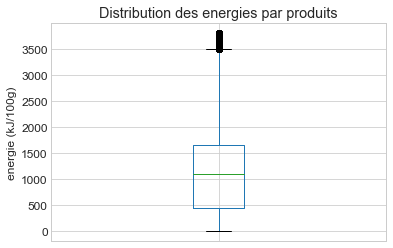

In [45]:
data["energy_100g"].plot(kind='box',
                         label='',
                         title='Distribution des energies par produits',
                         ylabel='energie (kJ/100g)');

In [46]:
data.shape

(615404, 44)

Masse

In [47]:
def poids_masque(data, min,max):
    """calcul du masque pour avoir les valeurs dans l´intervalle souhaité"""
    masque = ( data > min ) & ( data < max )
    return masque

In [48]:
    def poids(data):
        """On encadre le poids total et le poids de chaque nutriment"""
        seuil_min_poids = 0
        seuil_max_poids = 100

        nutriments_liste = ['fat_100g','carbohydrates_100g','proteins_100g','salt_100g']
        nutriments_liste_sous_groupe= ['saturated-fat_100g','sugars_100g','fiber_100g']

        ## sous groupe
        for nutriment in nutriments_liste_sous_groupe:
            masque = poids_masque(data[nutriment],-1,101)
            data.loc[~masque,nutriment]=np.nan

        ## groupe
        masque_nutriments = poids_masque(data['fat_100g'],-1,101)
        for ind_nutriments in nutriments_liste:
            masque_nutriments &= poids_masque(data[ind_nutriments],-1,101) == True

        ## poids total
        data_somme=0
        for ind_nutriments in nutriments_liste:
            data_somme += data[ind_nutriments]
        masque_nutriments_somme = poids_masque(data_somme,-1,101)

        masque_poids = masque_nutriments_somme & masque_nutriments

        return data[masque_poids].copy()

In [49]:
data = poids(data)

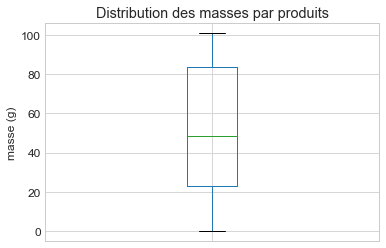

In [50]:
(data['fat_100g']+data['proteins_100g']+data['carbohydrates_100g']+data['salt_100g']).plot(kind='box',
                label='',
                title='Distribution des masses par produits',
                ylabel='masse (g)');

**Ecriture du fichier de sortie avec le jeu de donnée pretraité**

In [51]:
data.shape

(596889, 44)

In [52]:
ecriture_fichier(data,mon_fichier)

In [53]:
def pretraitement(mon_fichier,enregistrement=False):
    """
    Fonction de pretraitement global des données
    
    En entree, le nom du fichier.csv,
    enregistrement: sauvegarde le resultat dans un autre fichier fichier_pretraitement.csv
    
    En sortie le jeu de donnees pretraité
    
    data = pretraitement('fichier.csv') 
    ou
    data = pretraitement('fichier.csv',enregistrement=True)
    """
    
    ## lecture du fichiers
    print('Lecture du fichier')
    data = lecture_fichier(mon_fichier,echantillon=False)
    
    ## selection des colonnes
    print('Selection des colonnes')
    data = retire_colonne(data)
    
    [data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts] = decoupage(data)
    
    [data_general_information,
     data_tags,
     data_ingredients,
     data_misc,
     data_nutrition_facts] = selection_colonnes(data_general_information,
                                                  data_tags,
                                                  data_ingredients,
                                                  data_misc,
                                                  data_nutrition_facts)
    
    data = pd.concat([data_general_information,data_tags,data_ingredients,data_misc,data_nutrition_facts],axis=1)
    
    ## selection des lignes
    print('Selection des lignes')
    data = selection_ligne_nutrition(data)
    data = selection_ligne_categorie(data)
    
    ## traitement des valeurs aberrantes
    print('Traitement des valeurs aberrantes')
    data = energie(data)
    data = poids(data)
    
    if enregistrement:
        ## ecriture du fichier
        print('Ecriture du fichier')
        ecriture_fichier(data,mon_fichier)
    
    return data
    

**Initiation machine learning**

**Peut on imputer la categorie unknown du pnns_groups_1 & pnns_groups_2 ?**

In [54]:
nom_categorie = 'pnns_groups_1'

In [55]:
data_knn[nom_categorie].value_counts()

unknown                    829396
Sugary snacks              134809
Milk and dairy products     84386
Fish Meat Eggs              84358
Cereals and potatoes        75570
Fat and sauces              64111
Beverages                   59531
Composite foods             51063
Fruits and vegetables       45940
Salty snacks                29897
Alcoholic beverages          2402
Name: pnns_groups_1, dtype: int64

In [56]:
nutriments_energie_liste = ['fat_100g',
                            'carbohydrates_100g',
                            'proteins_100g',
                            'salt_100g',
                            'saturated-fat_100g',
                            'sugars_100g',
                            'fiber_100g',
                            'energy_100g',
                            'nutrition-score-fr_100g']

In [57]:
data_knn.shape

(1461529, 44)

In [58]:
data_sample = data_knn[~data_knn[nom_categorie].isin(['unknown'])].sample(frac=1/10,random_state=1)

In [59]:
data_sample.shape

(63213, 44)

In [60]:
masque_na_nutriments = data_sample[nutriments_energie_liste].notna().all(axis=1)
masque_na_energie = data_sample[nom_categorie].notna()
masque_na = masque_na_nutriments & masque_na_energie

In [61]:
data_etude = data_sample[nutriments_energie_liste][masque_na]
target = data_sample[nom_categorie][masque_na]

In [62]:
data_etude.shape

(29881, 9)

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
xtrain, xtest, ytrain, ytest = train_test_split(data_etude, target, train_size=0.8)

In [65]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=3)

In [66]:
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.212314


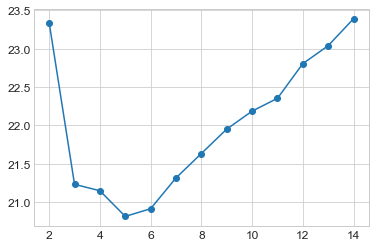

In [67]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [68]:
pd.DataFrame(errors,columns=['Erreur']).describe() ## erreur de ~20% et ~3% d´amplitude suivant k

,Erreur
count,13.000000
mean,22.008726
std,0.918332
min,20.813117
25%,21.231387
50%,21.950811
75%,22.804082
max,23.389660


In [69]:
# # On récupère le classifieur le plus performant
# knn = neighbors.KNeighborsClassifier(4)
# knn.fit(xtrain, ytrain)

# # On récupère les prédictions sur les données test
# predicted = knn.predict(xtest)
